# AirMont chimney sensor mock data generation  
Generates semi-realistic sensor data for chimney sensors following AirMonts data schema.  

This notebook is divided into three parts:  
1. Declaring data generation functions  
2. Generate mock data methods  
3. Importing locations and producing mock data

## Declaring data generation functions  
This section includes plots to viszualize the data from the declared methods

In [39]:
import matplotlib.pyplot as plt
import datetime 
from copy import deepcopy
from tqdm import tqdm
import random
import sys
import numpy as np
import math
import math
from pydoc import resolve
from tokenize import Double
from typing import Tuple
import numpy as np
import csv
import geopy.distance
import random
import datetime 
from scipy import rand
from dataclasses import dataclass

plt.rcParams['figure.figsize'] = [14, 5]

#### Perlin noise
Perlin noise is a random wave function producing a smother result than a noise function, but still more random than a simple sine function.  
In this code it is used in multiple implementations as an extra layer of randomness to make the underlying pattern less obvious.

In [12]:
def perlin(x): return 0.3 * (-3.2 * np.sin(-1.3 * x) - 1.2 * np.sin(-1.7 * math.e * x) + 1.9 * np.sin(0.7 * math.pi * x))

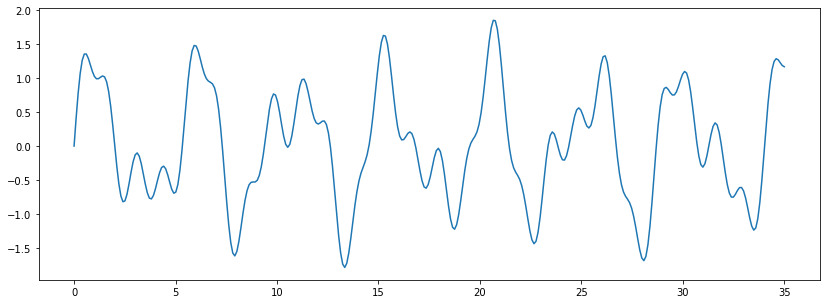

In [13]:
x = np.linspace(0, 35, 35*10)
y = perlin(x)
plt.plot(x, y)
plt.show()

#### Temperature probability
Simple sine defining probability of low temperature.  
Added perlin on top for randomness

In [14]:
def pure_sine(x): return 1 - (np.sin( ( (x + 240) * 2 * math.pi) / 365) + 1) * 0.5

def temperature_multiplier(x): return np.abs((pure_sine(x)) + (perlin(x/6)/20))

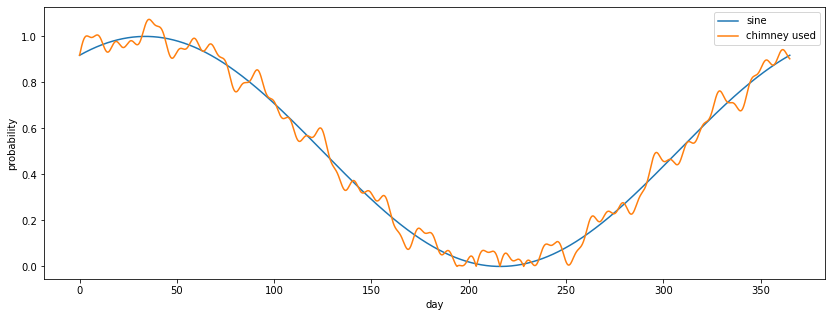

In [15]:
x = np.linspace(0, 365, 365*10)
y1 = pure_sine(x)
y2 = temperature_multiplier(x)
plt.plot(x, y1, label="sine")
plt.plot(x, y2, label="chimney used")
plt.xlabel("day")
plt.ylabel("probability")
plt.legend()
plt.show()

#### Location probability
Assume for dataset that those outside of city center use fireplace more.  
Represent location probability with modified sigmoid function and distance from centre

In [16]:
def pure_sig(x): return 0.1 + ( 1/(1 + np.exp(3 + (-x / 2))) ) / 1.3

def sig(x): return pure_sig(x) + (perlin(x*2.5)/50)

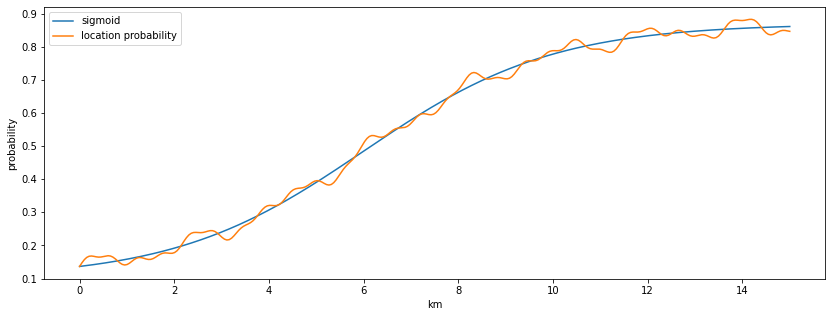

In [17]:
x = np.linspace(0, 15, 15*20)
y1 = pure_sig(x)
y2 = sig(x)
plt.plot(x, y1, label="sigmoid")
plt.plot(x, y2, label="location probability")
plt.xlabel("km")
plt.ylabel("probability")
plt.legend()
plt.show()

#### Distance calculation  
For the aformentioned location method a function for calculation the distance to the city center

In [18]:
halden_center = (59.125832, 11.389420)
def dist_from_center(coords): return geopy.distance.geodesic(halden_center, coords).km

halden_locations = [(59.121923, 11.386295), (59.115282, 11.395904), (59.111325, 11.399639), (59.094933, 11.413677), (59.082637, 11.425638), (59.049084, 11.453741), (59.01241, 11.479967), (58.941804, 11.504606)]


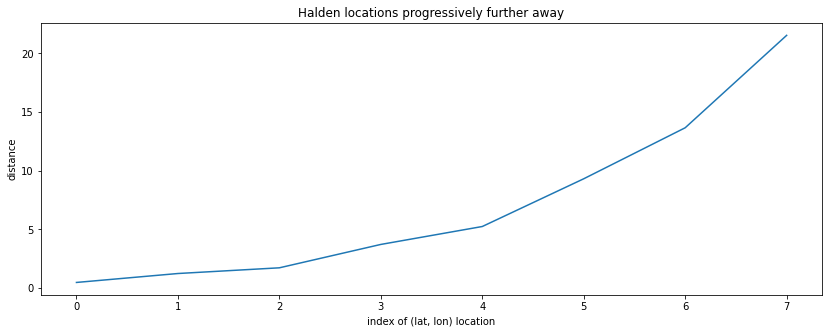

In [19]:
halden_locations = [
    (59.121923, 11.386295),
    (59.115282, 11.395904),
    (59.111325, 11.399639),
    (59.094933, 11.413677),
    (59.082637, 11.425638),
    (59.049084, 11.453741),
    (59.012410, 11.479967),
    (58.941804, 11.504606)
]

print(f"{halden_locations = }")
x = list(range(len(halden_locations)))
y = [dist_from_center(i) for i in halden_locations]

plt.title("Halden locations progressively further away")
plt.plot(x, y)
plt.xlabel("index of (lat, lon) location")
plt.ylabel("distance")
plt.show()

## Generate mock data methods  
This section implements the different mock data generation methods.  
The data schema includes four different kind of measurements: `[burn:count, burn:amount, burn:soot, burn:max]`  

In [20]:
@dataclass # class Point
class Point:
    id: str
    value: float
    seriesName: str
    komtekLocationReferenceId: str
    resolution: str
    unit: str
    timestamp: str

    def toRow(self): return [self.id, self.value, self.seriesName, self.komtekLocationReferenceId, self.resolution, self.unit, self.timestamp]

    def getDefault():
        return Point(id="",seriesName="77db43ae-fb4d-4481-bc18-fff1d5aaf87b",resolution="P7D",value=None, komtekLocationReferenceId=None, unit=None, timestamp=None)

    def new(self, unit, series, value):
        result = Point.getDefault()
        result.komtekLocationReferenceId = self.komtekLocationReferenceId
        result.unit = unit
        result.seriesName = series
        result.value = value
        return result

In [44]:
# util general functions
TIMESERIES_RESOULTION_DAYS = 7

def when_person_moves(first = False): 
    index = (365 / TIMESERIES_RESOULTION_DAYS)
    first_offset = (5 + (random.random()*3)) if first else 0 
    return int((( random.random() * 8 ) + 1 - first_offset ) * index)

def timeseries_delta(x): 
    NOW = datetime.datetime.today()
    new_time = (NOW + datetime.timedelta(days=x*TIMESERIES_RESOULTION_DAYS))
    return new_time.timetuple().tm_yday 

In [28]:
class probability_generator:

    def __init__(self, location):
        self.dist_multiplier = 0.7 + sig(dist_from_center((location.lat, location.lon))) 
        self.index = 0
        self.point = Point.getDefault()
        self.point.komtekLocationReferenceId = location.uuid
        self.new_personality(True)

    def new_personality(self, isFirst=False): 
        self.person_moves_index = self.index + when_person_moves(first=isFirst)
        self.personality_multiplier = 0.6 + (random.random() * 0.4)
        

    def next(self):
        
        # generate new probabilities
        if(self.index == self.person_moves_index): self.new_personality()

        temp_multiplier = temperature_multiplier(timeseries_delta(self.index))

        # burn chance combined from probabilities
        burn_chance = max(1, temp_multiplier * self.dist_multiplier * self.personality_multiplier)

        self.index += 1
        return burn_chance

In [22]:
def get_burn_count(burn_chance): return int(burn_chance * ((1+BASE_BURN_CHANCE)/7) * ( random.random()+ BASE_BURN_CHANCE) )

def get_burn_minutes(burn_count): return int(burn_count * 60 * (0.2 + random.random() * 0.8) * 5)

def get_soot_minutes(burn_minutes): return int(burn_minutes * positive(random.random() - 0.8))

In [43]:

BASE_BURN_CHANCE = 0.3 #guaranteed lowest random number burn chance will be multiplied by

def generate_points(location, point_count):

    prob = probability_generator(location)

    for _ in range(point_count):

        burn_chance = prob.next()
        
        burn_count = get_burn_count(burn_chance)
        
        burn_minutes = get_burn_minutes(burn_count)
        
        soot_minutes = get_soot_minutes(burn_minutes)

        yield from (
            prob.point.new("Count" , "burn:start", burn_count  ), 
            prob.point.new("Minute", "burn"      , burn_minutes), 
            prob.point.new("Minute", "burn:soot" , soot_minutes)
        )

## Importing locations and producing mock data
This section produces the actual data  

Import all locations from a csv file. This has been generated from [kartverket.no](https://kartverket.no/)  
For every building generate sensor readings (points) of different types.  
Finally export the result into a csv file.

In [45]:
headers= ["id","Value","SeriesName.Value","Chimney.KomtekLocationReferenceId","Resolution.Value","Unit.Value","Timestamp"]

In [42]:
@dataclass # class Location
class Location:
    uuid: str
    lat: float
    lon: float

def csv_float(x): return float(x.replace(',','.'))

def get_locations(path) -> list[Location]:
    with open(path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=";")
        next(reader) # skip headers
        
        for i in reader: yield Location(uuid = i[33], lat = csv_float(i[17]), lon = csv_float(i[17]))

In [26]:
class output_file():
    def __init__(self, name): self.name = name
    def __enter__(self):
        self.f = open(self.name, 'w', newline='', encoding='utf-8')
        writer = csv.writer(self.f, delimiter=";")
        writer.writerow(headers)
        return writer
    def __exit__(self, type, value, traceback): self.f.close()

Main method takes input and produces output using generate_points method

In [41]:
location_csv = "locations.csv"
output_csv = "output.csv"
point_count = 2

with output_file(output_csv) as writer:    
    for location in tqdm(get_locations(location_csv)):
        for point in generate_points(location, point_count):
            writer.writerow(point.toRow())

14307it [00:03, 3633.06it/s]
